## Import

In [2]:
import random
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import IsolationForest

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

c:\Users\chang\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 초기값

In [3]:
CFG = {
    'SR':16000,
    'N_MFCC':128, # MFCC 벡터를 추출할 개수 (<=128)
    'SEED':41
}

In [4]:
# seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

### 데이터 전처리

In [5]:
train_df = pd.read_csv('dataset/train.csv') # 모두 정상 Sample
test_df = pd.read_csv('dataset/test.csv')

Text(13.222222222222216, 0.5, 'Amplitude')

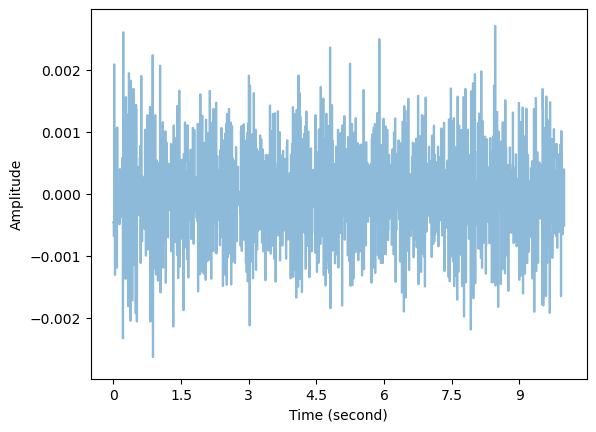

In [31]:
path = "dataset"+train_df["SAMPLE_PATH"][0]
y, sr = librosa.load(path, sr=120)
plt.figure()
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.xlabel("Time (second)")
plt.ylabel("Amplitude")

(128, 3)


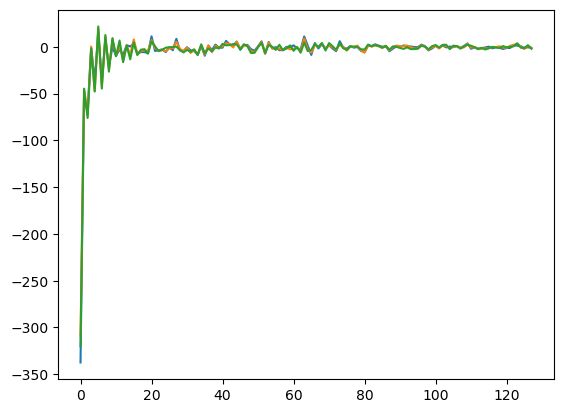

In [33]:
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])
print(mfcc.shape)
plt.plot(mfcc)

In [8]:
def get_mfcc(df):
    mfcc_lst = []
    for path in tqdm(df['SAMPLE_PATH']):
        # 경로 재지정
        path = "dataset/" + path

        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])        
        mfcc_lst.append(mfcc)
        
    mfcc_lst = np.array(mfcc_lst)
    return mfcc_lst

In [9]:
# train_mfcc = get_mfcc(train_df)
# test_mfcc = get_mfcc(test_df)

In [10]:
train_mfcc = np.load("dataset/npy/train_mfcc_sr_16000.npy")
test_mfcc = np.load("dataset/npy/test_mfcc_sr_16000.npy")

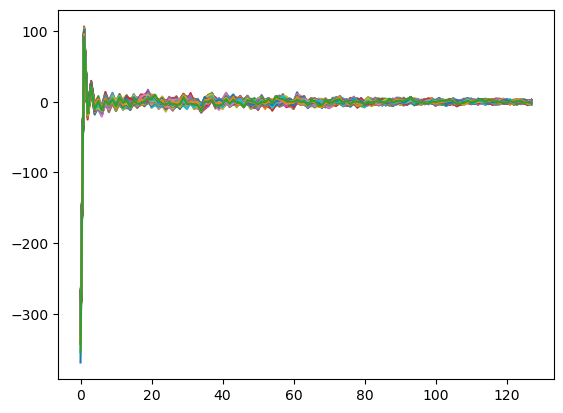

In [18]:
plt.plot(train_mfcc[0])

In [19]:
def get_features(input_mfcc):
    feature = []
    for mfcc in input_mfcc:
        quan_25 = np.quantile(mfcc,0.25)
        quan_50 = np.quantile(mfcc,0.5)
        quan_75 = np.quantile(mfcc,0.75)
        feature.append([np.mean(mfcc),np.min(mfcc),quan_25,quan_50,quan_75,np.max(mfcc)])
    feature = np.array(feature)
    return feature

In [20]:
train_features = get_features(train_mfcc)
test_features = get_features(test_mfcc)

In [21]:
train_features.shape,test_features.shape

((1279, 6), (1514, 6))

In [11]:
# # fan type load
# train_fan_type = train_df["FAN_TYPE"].values.reshape(-1,1)
# test_fan_type = test_df["FAN_TYPE"].values.reshape(-1,1)
# train_features_all = np.concatenate([train_features,train_fan_type],axis=1) 
# test_features_all = np.concatenate([test_features,test_fan_type],axis=1) 

## Model Fit

In [22]:
model = IsolationForest(n_estimators=200, max_samples=256, contamination='auto', random_state=CFG['SEED'], verbose=0)
model.fit(train_features)

IsolationForest(max_samples=256, n_estimators=200, random_state=41)

## Prediction

In [23]:
def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량) 이므로 (0:정상, 1:불량)로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [24]:
test_pred = model.predict(test_features) # model prediction
test_pred = get_pred_label(test_pred)

## Submission

In [25]:
submit = pd.read_csv('dataset/sample_submission.csv')

In [26]:
submit['LABEL'] = test_pred
submit.head()

,SAMPLE_ID,LABEL
0,TEST_0000,0
1,TEST_0001,1
2,TEST_0002,1
3,TEST_0003,1
4,TEST_0004,1


In [27]:
submit.to_csv('./submit.csv', index=False)

In [28]:
df = pd.read_csv("submit.csv")
Counter(df["LABEL"])

Counter({0: 728, 1: 786})